# tracevec

**Learning word embedding models (_Word2Vec and Doc2Vec_) based on the electrical consumption of various home appliances.**

The project consists of five connecting parts, which are:
1. [**Training word embedding models**](#1_training_word_embedding_models) (_using [Gensim](https://radimrehurek.com/gensim/) topic modelling library_)
2. [**Clustering**](#2_clustering) (_Doc2Vec vectors into clusters_)
3. [**Classification**](#3_classification) (_of the electrical device type using Doc2Vec vectors_)
4. [**Prediction**](#4_prediction) (_of the next electricity consumption category using Word2Vec vectors_)
5. [**RNN Forecasting**](#5_rnn_forecasting) (_the next electricity consumption category using RNN with GRU_)

We first train the `Doc2Vec` model, where each vector represents one device, and then the `Word2Vec` model, where each vector represents one power consumption category. Trained vectors are analyzed by **clustering**, **classification**, and **predicting the next consumption**, which is performed in two different ways. The first way is to guess the next word using the `Word2Vec` model, and the second is done using the `RNN` with `GRU`. With the project, we wanted to test whether the learned vectors capture the original different patterns of electricity consumption.

All data sets required to run the code are included in the [tracevec](https://github.com/mpinta/tracevec) repository. If you are running code without the included data sets, it is only necessary to clone the [tracebase](https://github.com/areinhardt/tracebase) repository, which represents projects main data set, into the `datasets` directory. All the other modified data sets (_consumptions, samples, forecast-train and forecast-test_) are gradually created by the notebook code itself. The tracebase data set is not our property and is used only as a depencency (_submodule_) - we appreciate the work done by the authors. You can find our `Word2Vec` and `Doc2Vec` models in the `models` directory (_skip the model part training if you don’t want to create new ones_).

#### Imports

In [180]:
import os
import csv
import glob
import torch
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from torch import nn
from matplotlib import rcParams
from collections import Counter
from sklearn import preprocessing
from matplotlib_venn import venn3
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from torch.autograd import Variable
from gensim.models import Doc2Vec, Word2Vec
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from gensim.models.doc2vec import TaggedDocument
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

#### Setups

In [181]:
sns.set_theme(style='whitegrid')

In [182]:
rcParams['figure.figsize'] = 11.7, 8.27

#### Helper functions

In [183]:
def create_dirs(path):
    """
    The function creates new directories.
    
    Args:
        path [str]: Path of directories to create.
        
    Returns:
        Function does not return anything.
    """
    
    if not os.path.exists(path):
        os.makedirs(path)

In [184]:
def file_to_string_array(path):
    """
    The function reads file into a string array.
    
    Args:
        path [str]: Path to read file from.
        
    Returns:
        [list]: File data in a string format.
    """
    
    with open(path, 'r') as f:
        return f.read().split()

In [185]:
def file_to_int_array(path):
    """
    The function reads file into an integer array.
    
    Args:
        path [str]: Path to read file from.
        
    Returns:
        [numpy.ndarray]: File data in an integer format.
    """
    
    with open(path, 'r') as f:
        return np.array(list(map(int, [r for r in csv.reader(f, delimiter=' ')][0])))

<a id='1_training_word_embedding_models'></a>

## 1. Training word embedding models

**Vectorization, more precisely the construction of `Doc2Vec` and `Word2Vec` models, is the first task we will perform.**

The original `tracebase` data set consists of several device directories and associated files, but they are not in the correct date sequence. Because a lot of measurements are taken a few days apart, power consumption data needs to be properly processed and broken down into smaller separate devices, as these are then used to train the models. `tracebase` contains several different subsets - will use its `complete` data set. This part of the notebook presents the transformer and the associated functions that are used to pre-process and change the power consumption of devices to the appropriate format. Finally, learning the models and reviewing the obtained vectors follows.

> [*The Tracebase data set is a collection of power consumption traces which can be used in energy analytics research.*](https://github.com/areinhardt/tracebase)

### 1.1 Preparing power consumption data

Let’s prepare the paths to the `tracebase` data set, `consumptions` directory, `Doc2Vec` and `Word2Vec` models.

In [186]:
tracebase_path = 'datasets/tracebase/complete/'

In [187]:
consumptions_path = 'datasets/consumptions/'

In [188]:
d2v_model_path = 'models/d2v_model.bin'

In [189]:
w2v_model_path = 'models/w2v_model.bin'

We also need to determine the **mapping ranges** that will be used to digitize each consumption value into a whole number. These numbers will help us monitor different patterns of power consumption rather than actual power consumption values. 

In [190]:
maximum = 3
minimum = 1.1
steps = 0.2

intervals = np.arange(minimum, maximum, steps)
mapping = np.sort(np.concatenate([intervals, 1 / intervals]))

print(mapping)

[0.34482759 0.37037037 0.4        0.43478261 0.47619048 0.52631579
 0.58823529 0.66666667 0.76923077 0.90909091 1.1        1.3
 1.5        1.7        1.9        2.1        2.3        2.5
 2.7        2.9       ]


The following functions must be defined for the operation of the transformer class.

In [191]:
def write_to_consumptions(dirname, filename, array, dir_path):
    """
    The function writes transformed consumption of a device into a file.
    
    Args:
        dirname  [str]:           Device directory name.
        filename [str]:           Device file name.
        array    [numpy.ndarray]: Consumption data to write.
        dir_path [str]:           Path to write consumption to.
        
    Returns:
        Function does not return anything.
    """
    
    create_dirs(dir_path + dirname)
    
    with open(dir_path + dirname + os.sep + filename + '.csv', 'w') as f:
        np.savetxt(f, array, fmt='%d', newline=' ')

In [192]:
def find_unique_filenames(path, dirname):
    """
    The function finds unique file names in the directory.
    
    Args:
        path    [str]: Path to search from.
        dirname [str]: Device directory name.
        
    Returns:
        [list]: Unique file names in the directory.
    """
    
    filenames = []
    
    for i in glob.glob(os.path.join(path + dirname, '*.csv')):
        filename = i.rsplit(os.sep, 1)[1]
        cut = -2 if filename.rsplit('_')[-1] == 'CRT-TV.csv' else -1  
        filenames.append('_'.join(filename.rsplit('_')[:cut])) 
        
    return sorted(list(set(filenames)))

In [193]:
def split_and_digitize_series(series, unique_dates, mapping):
    """
    The function splits and digitizes series data based on device unique dates.
    
    Args:
        series       [pandas.Series]: Device consumption data to split.
        unique_dates [list]:          Device unique dates.
        mapping      [numpy.ndarray]: Mapping ranges.
        
    Returns:
        [list]: Splitted series data.
    """
    
    current = []
    splitted = []
    
    for i, v in series.items():
        if i.strftime('%Y-%d-%m') in unique_dates:
            current.append(v)
        elif len(current) > 0:
            splitted.append(np.digitize(np.array(current), mapping))
            current = []
    
    splitted.append(np.digitize(np.array(current), mapping))
    
    return splitted

In [194]:
def dropout_last(array, drop_perc):
    """
    The function drops given percent of last consumption data.
    
    Args:
        array     [numpy.ndarray]: Consumption data to drop from.
        drop_perc [float]:         Percent of last consumption data to drop.
    
    Returns:
        [numpy.ndarray]: Consumption data on which dropping was performed.
    """
    
    return array[:-int(round(len(array) * drop_perc))]

The **transformer class** converts power consumption data into the appropriate format for training the `Doc2Vec` and `Word2Vec` models.
1. Depending on the number of devices, the class opens the device folder and obtains its unique file names. 
2. It then goes through them and retrieves the paths of all the files in the folder, that contain the current name.
3. Then it reads and combines the data of these files, removes one column, and changes the format of the date time column. 
4. This is followed by sorting the data according to the date time column, setting up a new index, grouping the data frame by index and summing the duplicated rows. 
5. Next, unique dates are obtained, the data is resampled and divided by its average value. 
6. In the end, several separate devices are created from the data frame according to previously obtained unique dates. In doing so, their consumption is digitized according to the mapping ranges. 
7. Depending on which model is being trained, the mapped consumption is returned either as a `TaggedDocument` or as a `list`, with some percentage of last consumption dropped from it.

In [195]:
class Transformer(object):
    """
    A class used to transform power consumption data.
    
    Attributes:
        path      [str]:           Data set path.
        mapping   [numpy.ndarray]: Mapping ranges.
        n_devices [int]:           Number of devices to read.
        agg_time  [str]:           Time-series resampling conversion value.
        drop_perc [float]:         Percent of last consumption data to drop.
        doc       [bool]:          Indicating if Doc2Vec is being trained.
        names     [list]:          Data frame column names.
    """
    
    def __init__(self, path, mapping, n_devices, agg_time='5T', drop_perc=0.3, doc=False):
        self.path = path
        self.mapping = mapping
        self.n_devices = n_devices
        self.agg_time = agg_time
        self.drop_perc = drop_perc
        self.doc = doc
        self.names = ['datetime', '1s_average', '8s_average']

    def __iter__(self):
        for dirname in os.listdir(self.path)[:self.n_devices]:
            tag = -1
            unique_filenames = find_unique_filenames(self.path, dirname)

            for filename in unique_filenames:
                files = [i for i in glob.glob(os.path.join(self.path + dirname, '*.csv')) 
                         if filename in i.rsplit(os.sep, 1)[1]]

                df = pd.concat([pd.read_csv(i, sep=';', names=self.names) for i in files], ignore_index=True)
                df.drop(['8s_average'], axis=1, inplace=True)
                df['datetime'] = pd.to_datetime(df['datetime'].astype(str), format='%d/%m/%Y %H:%M:%S')
                df.sort_values(by='datetime', ascending=True, inplace=True)
                df.set_index('datetime', inplace=True)
                df = df.groupby(level=0).sum()

                unique_dates = [i.strftime('%Y-%d-%m') for i in df.index.map(pd.Timestamp.date).unique()]
                
                df_r = df.resample(self.agg_time)['1s_average'].sum()
                df_r = df_r / df_r.mean()
                
                for i in split_and_digitize_series(df_r, unique_dates, self.mapping):
                    if self.doc:
                        tag += 1
                        write_to_consumptions(dirname.lower(), str(tag) + '_' + dirname.lower(), 
                                              i, consumptions_path)
                        yield TaggedDocument(np.char.mod('%d', i).tolist(), [str(tag) + '_' + dirname.lower()])
                    else:
                        yield np.char.mod('%d', dropout_last(i, self.drop_perc)).tolist()

### 1.2 Training Doc2Vec model

Here we define **parameters**, which are same for training both the `Doc2Vec` and `Word2Vec` models. We will train  the models using `Gensim` library.

> [*Gensim is an open-source library for unsupervised topic modeling and natural language processing.*](https://radimrehurek.com/gensim/)

In [196]:
window_size = 5
vector_size = 50

n_epochs = 200
n_devices = 43
n_workers = multiprocessing.cpu_count() - 1

In order to train the model, we need to create new `Transformer` and `Doc2Vec` objects.

> [*Doc2Vec is a model that represents each document as a vector.*](https://radimrehurek.com/gensim/models/doc2vec.html)

In [197]:
d2v_transformer = Transformer(tracebase_path, mapping, n_devices=n_devices, doc=True)

In [198]:
d2v_model = Doc2Vec(vector_size=vector_size, window=window_size, workers=n_workers)

After that, a **vocabulary** needs to be built and then the model can be **trained** and **saved**. 

In [199]:
d2v_model.build_vocab(d2v_transformer)

In [200]:
d2v_model.train(d2v_transformer, total_examples=d2v_model.corpus_count, epochs=n_epochs)

In [201]:
d2v_model.save(d2v_model_path)

Let's load newly created `Doc2Vec` model and print some of its **properties** below.

In [202]:
d2v_model = Doc2Vec.load(d2v_model_path)

These are vocabulary length, vocabulary words, a sample of vector names and an actual example of a `0_toaster` device vector. 

In [203]:
print(len(list(d2v_model.wv.vocab)))

21


In [204]:
print(list(d2v_model.wv.vocab))

['0', '20', '2', '4', '5', '7', '3', '8', '6', '18', '19', '9', '17', '15', '16', '14', '11', '13', '12', '10', '1']


In [205]:
print(d2v_model.docvecs.index2entity[:5])

['0_toaster', '1_toaster', '2_toaster', '3_toaster', '4_toaster']


In [206]:
print(d2v_model['0_toaster'])

[ 0.25131676 -0.5422203   0.6973609  -0.02512717  0.56432164  0.11338314
 -0.22850733 -0.638559    0.13102405 -0.28289267 -0.32152718 -0.32209548
  0.5892098  -0.10315282  0.16415334  0.5954432   0.45891964 -0.69004554
 -0.9453215   0.37720335 -0.08026756  0.3616484   0.41242233 -0.08861385
  0.41390908  0.338499    0.7038394   0.6721943   0.19987959 -0.6132844
  1.4496475  -0.20318168 -0.36810943 -0.82601875 -1.0772575  -0.28324795
  0.44871673  0.42344505  0.7580702  -0.70324457 -0.82988983  0.5306042
 -0.02509752  1.4340112   1.3418086  -0.5437436   0.03444461 -0.9632389
  0.61627346  1.5514088 ]


Because vector data is easiest to present in a **data frame**, we need to define the function for converting the `Doc2Vec` model into it.

In [207]:
def d2v_model_to_dataframe(model):
    """
    The function creates a data frame from Doc2Vec model.
    
    Args:
        model [gensim.Doc2Vec]: Doc2Vec model.
        
    Returns:
        [panda.DataFrame]: Data frame with Doc2Vec vector data.
    """
    
    return pd.DataFrame(model.docvecs[i] for i in model.docvecs.index2entity)

In [208]:
df_d2v = d2v_model_to_dataframe(d2v_model)

In [209]:
df_d2v.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.251317,-0.542220,0.697361,-0.025127,0.564322,0.113383,-0.228507,-0.638559,0.131024,-0.282893,...,-0.829890,0.530604,-0.025098,1.434011,1.341809,-0.543744,0.034445,-0.963239,0.616273,1.551409
1,0.283454,-0.945170,0.905071,0.197265,0.783477,0.062736,-0.456336,-1.057102,0.146308,-0.528121,...,-1.573930,0.854392,-0.144063,2.363049,2.326744,-0.808261,-0.214464,-1.494301,0.937580,2.623432
2,-0.087975,-0.275250,0.387133,0.388291,0.270675,0.090464,-0.185362,-0.455264,-0.164989,-0.221152,...,-0.703456,0.444184,-0.222669,0.800059,1.069233,-0.210168,-0.163844,-0.450154,0.585877,1.033662
3,0.125783,-1.024553,1.119424,0.506711,0.935346,0.167841,-0.369862,-1.260723,0.149401,-0.640517,...,-1.783431,1.170877,-0.181855,2.615109,2.654473,-0.749771,-0.281561,-1.741567,1.130616,3.163152
4,-0.402792,-0.012620,0.410766,0.705638,0.221510,0.226542,-0.070957,-0.516422,-0.399924,-0.203983,...,-0.632816,0.577174,-0.355534,0.528383,1.132488,0.076279,-0.233031,-0.387620,0.745580,0.854994


### 1.3 Training Word2Vec model

Before training the model, we need to recreate all the necessary objects, which are `Transformer` and `Word2Vec` objects.

> [*Word2Vec is a model that embeds words in a lower-dimensional vector space using a shallow neural network.*](https://radimrehurek.com/gensim/models/word2vec.html)

In [210]:
w2v_transformer = Transformer(tracebase_path, mapping, n_devices=n_devices)

In [211]:
w2v_model = Word2Vec(size=vector_size, window=window_size, workers=n_workers)

After that, we need to rebuild the **vocabulary**, start **training** the model and **save** it. 

In [212]:
w2v_model.build_vocab(w2v_transformer)

In [213]:
w2v_model.train(w2v_transformer, total_examples=w2v_model.corpus_count, epochs=n_epochs)

In [214]:
w2v_model.save(w2v_model_path)

Here we load newly created `Word2Vec` model and print some of its **properties**.

In [215]:
w2v_model = Word2Vec.load(w2v_model_path)

These are vocabulary length, vocabulary words and an actual example of a `0` consumption vector.

In [216]:
print(len(list(w2v_model.wv.vocab)))

21


In [217]:
print(list(w2v_model.wv.vocab))

['0', '20', '2', '4', '5', '7', '3', '8', '6', '18', '19', '9', '17', '15', '16', '14', '11', '13', '12', '10', '1']


In [218]:
print(w2v_model.wv['0'])

[-0.16483591 -2.627785    0.02058786  0.03126768  0.73000026  0.13671306
  0.28634915  0.8207739  -0.04503812  0.71593773 -0.9494604   0.30443463
  1.0695629  -2.3345072  -0.02407067  0.1034523  -0.7267006  -0.7716735
 -0.9812443   0.19766578  2.1132755   0.0659349   0.11627307 -1.9110117
 -0.06560331 -0.47028217 -0.2065368  -1.8414251   0.32779074 -0.45751464
  0.16330029 -0.14546116 -0.49462837 -0.09179021  0.30638048 -0.90382946
 -0.6957215   1.9362437  -0.34744295  0.12307446 -0.5325359   0.6307974
 -0.78562146 -0.0028429  -1.084195    1.9951036  -0.2936932  -1.2518326
  0.02299066  2.0401921 ]


As with `Doc2Vec`, we need to define a function to convert the `Word2Vec` model into a **data frame**. 

In [219]:
def w2v_model_to_dataframe(model):
    """
    The function creates a data frame from Word2Vec model.
    
    Args:
        model [gensim.Word2Vec]: Word2Vec model.
        
    Returns:
        [panda.DataFrame]: Data frame with Word2Vec vector data.
    """
    
    return pd.DataFrame(model.wv[i] for i in model.wv.vocab)

In [220]:
df_w2v = w2v_model_to_dataframe(w2v_model)

In [221]:
df_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.164836,-2.627785,0.020588,0.031268,0.730000,0.136713,0.286349,0.820774,-0.045038,0.715938,...,-0.532536,0.630797,-0.785621,-0.002843,-1.084195,1.995104,-0.293693,-1.251833,0.022991,2.040192
1,1.951559,2.659264,-1.505808,2.511912,-1.767032,-0.288314,-3.670078,-1.097207,-0.959779,-0.255822,...,1.507688,-0.712253,1.335687,-4.005666,-2.751504,-1.317367,0.395586,0.739340,-2.855621,4.122703
2,-0.626497,0.891378,3.644045,-1.865407,0.852793,0.486151,-2.308506,0.562205,1.079576,-1.113847,...,0.222462,0.747169,1.519686,1.345147,0.531670,-0.466570,-0.536966,0.900969,-0.010163,-1.451500
3,0.200071,2.852473,1.723763,0.807578,0.202305,1.909688,-3.145110,-1.580944,-0.229414,-0.431983,...,0.160816,-0.175354,1.068746,1.708935,1.902866,-0.788524,1.019361,1.109324,-0.776418,0.063942
4,0.612565,2.596014,1.302939,0.606638,0.120380,0.489317,-1.848691,-1.041271,-0.545641,-1.409320,...,0.043275,0.272504,1.935189,1.098960,0.784432,-1.261794,1.411864,0.749969,-0.874281,-0.000428


<a id='2_clustering'></a>

## 2. Clustering

**In this part of the notebook, we will group the previously trained `Doc2Vec` vectors into multiple clusters.**

We expect the vectors to be clustered according to similar patterns of their consumption. The consumption patterns of each of the clusters will be analyzed using descriptive statistics and plotted on different graphs. We will also check which devices have been classified into which clusters and whether they are also similar in practice.

### 2.1 Pre-processing Doc2Vec vectors

Since the `Doc2Vec` data frame is already created, we can use it to form a `StandardScaler` object and **standardize** the vectors.

> [*Standard scaler is used to standardize features by removing the mean and scaling to unit variance.*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [222]:
scaler = StandardScaler().fit(df_d2v)

In [223]:
df_scaled = pd.DataFrame(scaler.transform(df_d2v), columns=df_d2v.columns)

In [224]:
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.497156,-0.077846,0.930953,-0.650231,0.642511,0.371751,0.118699,-0.253927,-0.022182,-0.102402,...,-0.106796,0.207959,0.148327,0.646863,0.360268,-0.438273,0.375720,-0.705272,0.436089,0.644779
1,0.527769,-0.377313,1.103903,-0.459500,0.836582,0.322146,-0.032307,-0.689096,-0.011357,-0.424360,...,-0.832660,0.493899,0.037532,1.347437,1.137099,-0.648769,0.155678,-1.059545,0.713717,1.406443
2,0.173957,0.120564,0.672641,-0.295669,0.382476,0.349304,0.147296,-0.063351,-0.231845,-0.021342,...,0.016550,0.131640,-0.035676,0.168808,0.145285,-0.172823,0.200427,-0.362992,0.409825,0.276924
3,0.377577,-0.436309,1.282384,-0.194107,0.971068,0.425089,0.025009,-0.900805,-0.009167,-0.571924,...,-1.037043,0.773391,0.002335,1.537512,1.395583,-0.602224,0.096363,-1.224497,0.880511,1.789909
4,-0.125927,0.315747,0.692320,-0.023501,0.338939,0.482582,0.223124,-0.126938,-0.398246,0.001198,...,0.085464,0.249085,-0.159416,-0.036058,0.195175,0.055124,0.139265,-0.321276,0.547818,0.149982


Next task is the **normalization** of transformed vectors, which is performed using `preprocessing.normalize` function. 

> [*Normalization is the process of scaling individual samples to have unit norm.*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html)

In [225]:
df_norm = pd.DataFrame(preprocessing.normalize(df_scaled))

In [226]:
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.150756,-0.023606,0.282300,-0.197174,0.194833,0.112729,0.035994,-0.077000,-0.006727,-0.031052,...,-0.032385,0.063061,0.044978,0.196153,0.109247,-0.132901,0.113932,-0.213865,0.132239,0.195521
1,0.100187,-0.071626,0.209555,-0.087227,0.158809,0.061153,-0.006133,-0.130812,-0.002156,-0.080557,...,-0.158064,0.093757,0.007125,0.255785,0.215856,-0.123156,0.029552,-0.201134,0.135485,0.266986
2,0.092282,0.063958,0.356827,-0.156849,0.202898,0.185301,0.078138,-0.033607,-0.122991,-0.011322,...,0.008779,0.069833,-0.018926,0.089550,0.077072,-0.091680,0.106324,-0.192562,0.217407,0.146905
3,0.061192,-0.070710,0.207828,-0.031458,0.157375,0.068892,0.004053,-0.145988,-0.001486,-0.092688,...,-0.168067,0.125339,0.000378,0.249175,0.226174,-0.097599,0.015617,-0.198447,0.142699,0.290080
4,-0.058082,0.145633,0.319320,-0.010839,0.156329,0.222582,0.102912,-0.058548,-0.183684,0.000553,...,0.039419,0.114886,-0.073528,-0.016631,0.090021,0.025425,0.064233,-0.148183,0.252671,0.069177


Our vectors have many dimensions, more precisely they have as many as `50` columns. Since such vectors are almost impossible to visualize on graphs, they must first be **reduced to fewer components**. To do this, we will use the `t-SNE` (t-distributed Stochastic Neighbor Embedding) transformation and transform columns to `2` components.

> [*t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [227]:
n_components = 2

In [228]:
tsne_array = TSNE(n_iter=5000,
                  perplexity=30,
                  random_state=102,
                  learning_rate=300,
                  n_components=n_components).fit_transform(df_norm)

In [229]:
df_tr = pd.DataFrame(tsne_array, columns=[str(i) for i in range(n_components)])

Let's look at the shape of newly transformed data. It is seen that the number of rows is equal to `480` and the number of columns to only `2`. 

In [230]:
print(df_tr.shape)

(480, 2)


Here we plot transformed data on a `relplot` graph.

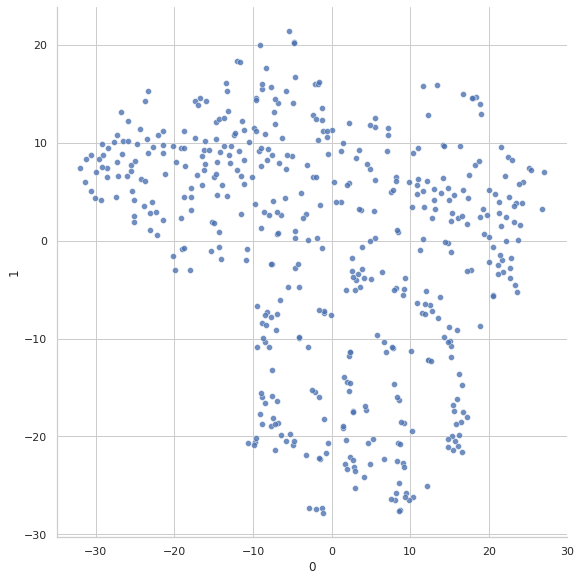

In [231]:
sns.relplot(x='0', y='1', alpha=.8, height=8, data=df_tr)
plt.show()

### 2.2 K-Means clustering

Before performing the vector clustering, we need to find the appropriate **number of clusters**. We will do this using the `dendrogram` graph.

> [*The dendrogram illustrates how each cluster is composed by drawing a U-shaped link between a non-singleton cluster and its children.*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)

In [232]:
linked = linkage(df_tr, method='complete', metric='cosine')

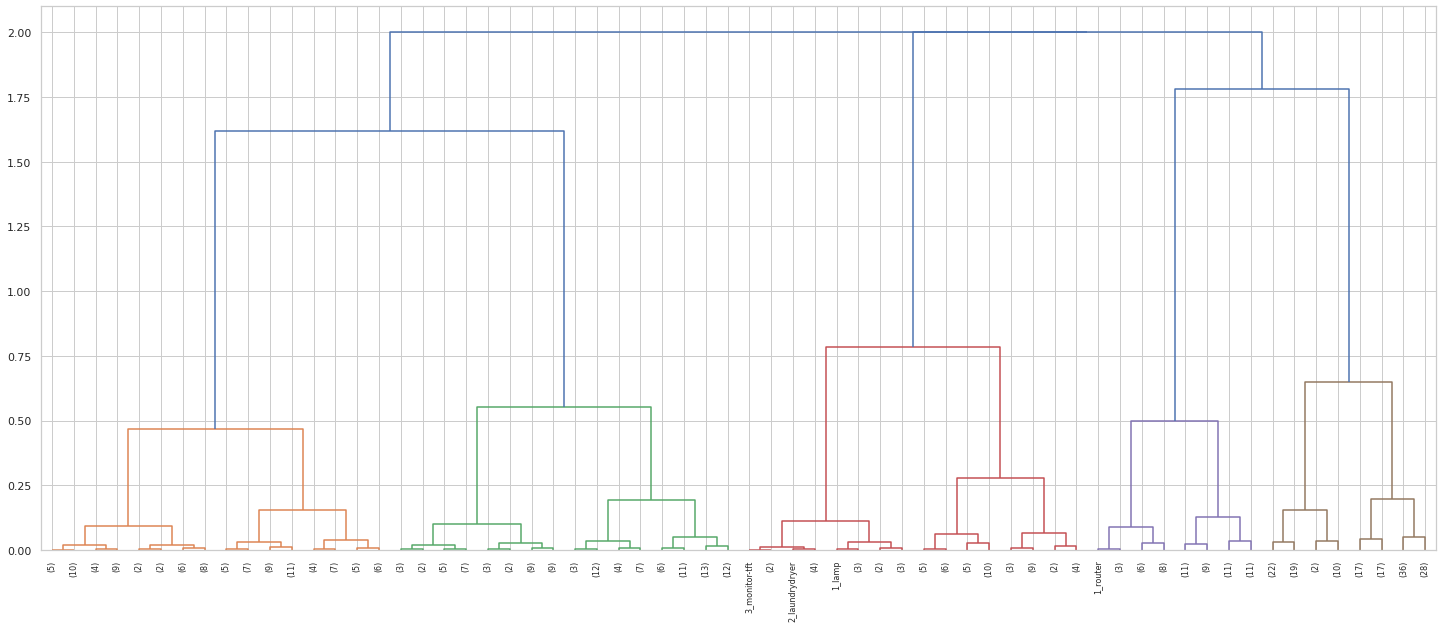

In [233]:
plt.figure(figsize=(25, 10))

dendrogram(p=5, 
           Z=linked,
           leaf_rotation=90,
           leaf_font_size=8,
           orientation='top',
           truncate_mode='level',
           labels=d2v_model.docvecs.index2entity)

plt.show()

Another method of finding the appropriate number of clusters is to calculate the `inertia` for several numbers of clusters and display results on the `lineplot` graph. We can do this using the `intertia_` attribute of the `KMeans` object.

> [*Inertia is a sum of squared distances of samples to their closest cluster center.*](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [234]:
def calculate_inertia(df, n):
    """
    The function calculates interia of a certain number of clusters.
    
    Args:
        df [pandas.DataFrame]: Data frame to calculate inertia from.
        n  [int]:              Number of clusters.
        
    Returns:
        [dict]: Inertia values for each of a certain number of clusters.
    """
    
    return {i:KMeans(n_clusters=i).fit(df).inertia_ for i in range(1, n + 1)}

In [235]:
n_inertia_clusters = 10

In [236]:
inertia = calculate_inertia(df_tr, n_inertia_clusters)

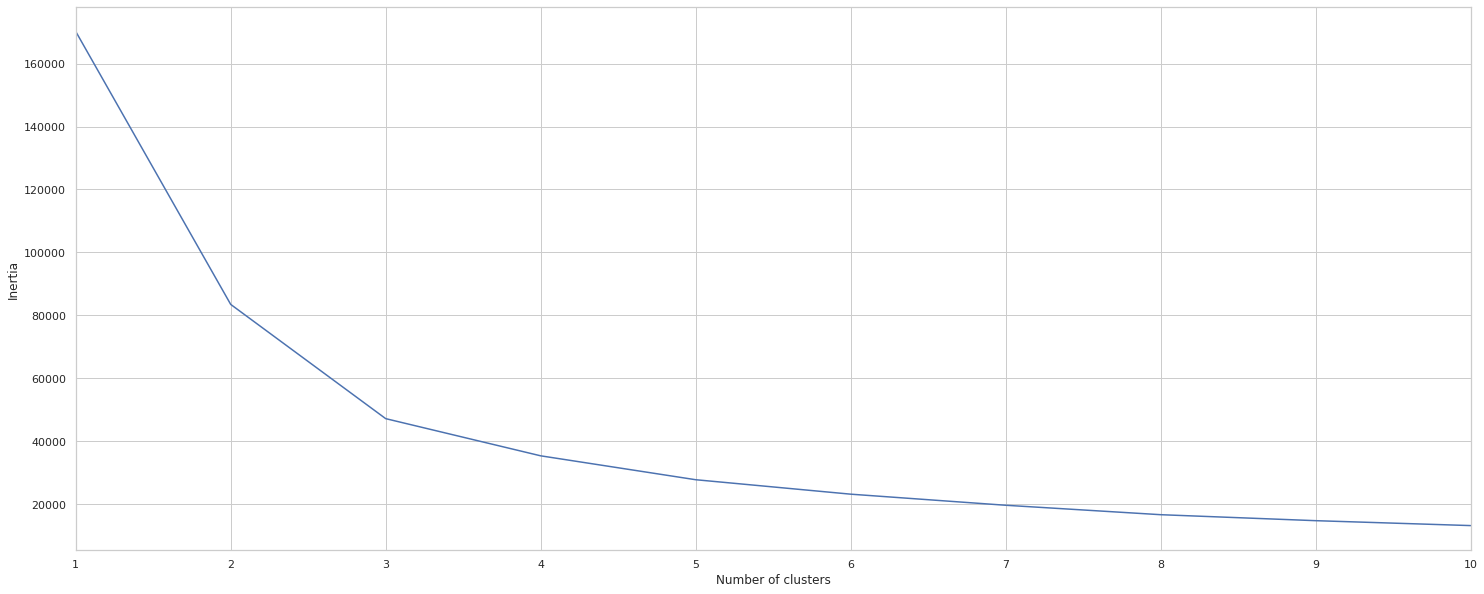

In [237]:
plt.figure(figsize=(25, 10))

sns.lineplot(x=list(inertia.keys()), y=list(inertia.values()))

plt.xlim([1, n_inertia_clusters])

plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

plt.show()

From the `dendrogram` and `inertia` graphs we can conclude, that the most suitable number of clusters is equal to `3`. We can now perform `K-Means` clustering of the `Doc2Vec` vectors into `3` clusters.

> [*The K-Means algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares.*](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [238]:
n_clusters = 3

In [239]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_tr)

Let’s look at the number of vectors assigned to each of the clusters.

In [240]:
print(Counter(kmeans.labels_))

Counter({1: 193, 2: 154, 0: 133})


Below, previously `t-SNE` transformed data are color marked and plotted on a `relplot` graph. The black dots represent the centers our `3` clusters.

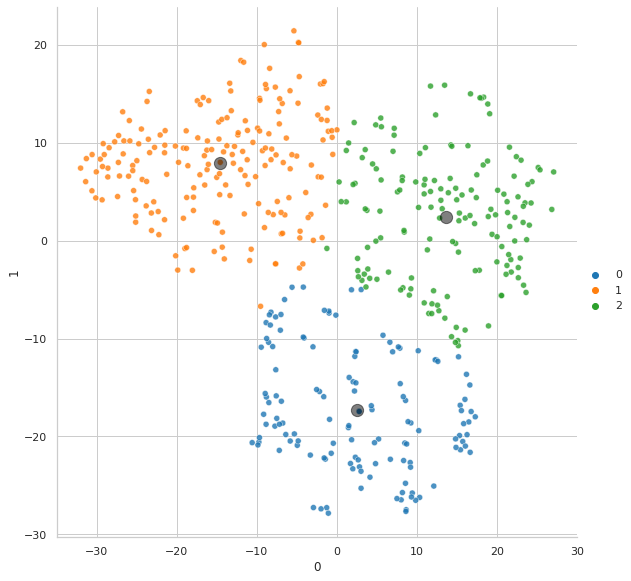

In [241]:
sns.relplot(x='0', y='1', hue=kmeans.labels_, alpha=.8, height=8, data=df_tr, palette='tab10')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=150, alpha=0.5)

plt.show()

### 2.3 Cluster consumption analysis

Here we create a data frame that stores data about the vectors and the clusters, that were assigned to them during `K-Means` clustering.

In [242]:
df_tc = pd.DataFrame({'tag': d2v_model.docvecs.index2entity, 'cluster': kmeans.labels_})

In order to analyze device consumption patterns, we must first read them. Therefore, we **read the mapped consumptions** that were prior saved during the training of the `Doc2Vec` model, using `write_to_consumptions` function.

In [243]:
def read_consumptions(tags, path):
    """
    The function reads devices consumption data.
    
    Args:
        tags [list]: Doc2Vec model vectors names.
        path [str]:  Path to read consumptions from.
        
    Returns:
        [dict]: Devices consumption data.
    """
    
    return {i:pd.read_csv(path + i.rsplit('_')[1] + os.sep + i + '.csv', 
                          header=None, delim_whitespace=True).T for i in tags}

In [244]:
consumptions = read_consumptions(d2v_model.docvecs.index2entity, consumptions_path)

Now, we need to **merge** the consumption of all devices per cluster together into one consumption column per cluster. 

In [245]:
def merge_by_clusters(df, consumptions, n_clusters):
    """
    The function merges consumption data by clusters.
    
    Args:
        df           [pandas.DataFrame]: Data frame of vectors names and their clusters.
        consumptions [dict]:             Devices consumption data.
        n_clusters   [int]:              Number of clusters.
        
    Returns:
        [dict]: Consumption data for each of the clusters.
    """
    
    return {i:pd.concat([consumptions[j] for j in get_cluster_tags(df, i)]) for i in range(0, n_clusters)}

In [246]:
def get_cluster_tags(df, cluster_n):
    """
    The function obtains device names of a particular cluster.
    
    Args:
        df        [pandas.DataFrame]: Data frame of vector names and their clusters.
        cluster_n [int]:              Cluster number.
        
    Returns:
        [pandas.Series]: Device names of a particual cluster.
    """
    
    return df.loc[df['cluster'] == cluster_n].tag

In [247]:
consumptions_c = merge_by_clusters(df_tc, consumptions, n_clusters)

Here we define and run a function that evaluates each cluster consumption data with **descriptive statistics**.

In [248]:
def describe_consumptions(consumptions_c, agg_functions, n_clusters):
    """
    The function describes each cluster consumption data with descriptive statistics. 
    
    Args:
        consumptions_c [dict]: Consumption data for each of the clusters.
        agg_functions  [list]: Additional functions for statistical analysis.
        n_clusters     [int]:  Number of clusters.
        
    Returns:
        [pandas.DataFrame]: Descriptive statistics data of each cluster.
    """
    
    df = pd.concat([pd.concat([consumptions_c[i].describe() for i in range(0, n_clusters)], axis=1), 
                    pd.concat([consumptions_c[i].agg(agg_functions) for i in range(0, n_clusters)], axis=1), 
                    pd.concat([consumptions_c[i].mode() for i in range(0, n_clusters)], axis=1)]).T
    df.rename(columns = {0: 'mode'}, inplace=True)
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    return df

In [249]:
agg_functions = ['sum', 'median', 'nunique']

In [250]:
describe_consumptions(consumptions_c, agg_functions, n_clusters)

,count,mean,std,min,25%,50%,75%,max,sum,median,nunique,mode
0,189297.0,8.819432,6.890723,0.0,0.0,10.0,14.0,20.0,1669492.0,10.0,21.0,0.0
1,174060.0,2.160445,6.054003,0.0,0.0,0.0,0.0,20.0,376047.0,0.0,21.0,0.0
2,161689.0,4.800110,7.998856,0.0,0.0,0.0,8.0,20.0,776125.0,0.0,21.0,0.0


We can see that results are not accurate due to the frequent occurrence of values `0` and `20`. Therefore, we define a new function that **removes** a given value from the data.

In [251]:
def remove_from_consumptions(consumptions_c, value):
    """
    The function removes particular value from consumption data.
    
    Args:
        consumptions_c [dict]: Consumption data for each of the clusters.
        value          [int]:  Particular consumption value to remove.
        
    Returns:
        [pandas.Series]: Consumption data for each of the clusters without particular value.
    """
    
    return {i:consumptions_c[i][consumptions_c[i][0] != value] for i in consumptions_c}

In [252]:
consumptions_c_r = remove_from_consumptions(remove_from_consumptions(consumptions_c, 0), 20)

In [253]:
describe_consumptions(consumptions_c_r, agg_functions, n_clusters)

,count,mean,std,min,25%,50%,75%,max,sum,median,nunique,mode
0,114407.0,11.505170,3.625526,1.0,9.0,11.0,14.0,19.0,1316272.0,11.0,19.0,10.0
1,4670.0,12.768094,4.677060,1.0,9.0,13.0,17.0,19.0,59627.0,13.0,19.0,19.0
2,21706.0,6.888648,4.840377,1.0,3.0,6.0,11.0,19.0,149525.0,6.0,19.0,1.0


### 2.4 Cluster consumption values analysis

Now let’s look at the **number of occurrences** of the consumption values per cluster. From this we will be able to find out whether the clusters were formed according to the consumption patterns of the devices. For this purpose, we define a new function that obtains the specified data. 

In [254]:
def get_consumption_freq(consumptions_c, n_clusters):
    """
    The function obtains the number of occurrences of each consumption value per cluster.
    
    Args:
        consumptions_c [dict]: Consumption data for each of the clusters.
        n_clusters     [int]:  Number of clusters.
        
    Returns:
        [pandas.DataFrame]: Occurrence data of each consumption value per cluster.
    """
    
    df = pd.concat([consumptions_c[i].value_counts() for i in range(0, n_clusters)], axis=1)
    df.index.names = ['Consumption value']
    df.reset_index(inplace=True)
    df.set_index('Consumption value', inplace=True)
    return df

In [255]:
df_f = get_consumption_freq(consumptions_c_r, n_clusters)

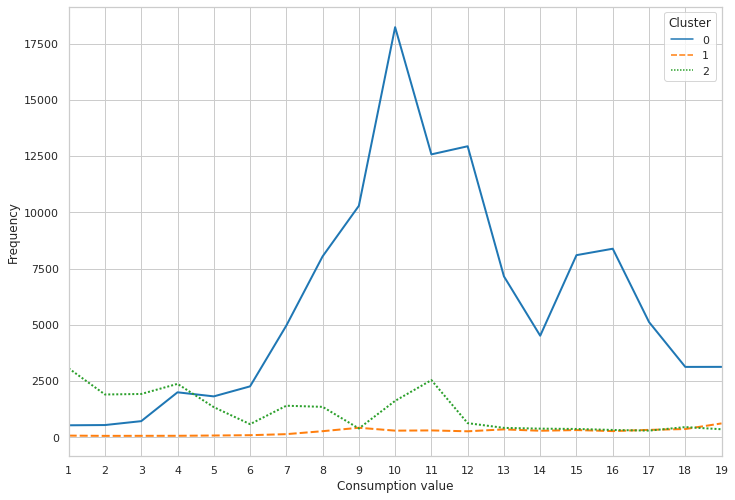

In [256]:
_, ax = plt.subplots()

sns.lineplot(data=df_f, linewidth=2, palette='tab10')

ax.set_xlim(df_f.index[0], df_f.index[-1])
ax.set_xticks(range(df_f.index[0], df_f.index[-1] + 1))

ax.set(ylabel='Frequency')
ax.legend(title='Cluster')

plt.show()

Because we also want to display the data in a **percentage** format, we define a function that will change the occurence data into percentages.

In [257]:
def get_freq_perc(df):
    """
    The function changes occurence data of each consumption value to percentages.
    
    Args:
        df [pandas.DataFrame]: Occurrence data of each consumption value per cluster.
        
    Returns:
        [pandas.DataFrame]: Occurrence data of each consumption value per cluster in percentages.
    """
    
    for i in df:
        df[i] = df[i] / df[i].sum()
    return df

In [258]:
df_fp = get_freq_perc(df_f.copy(deep=True))

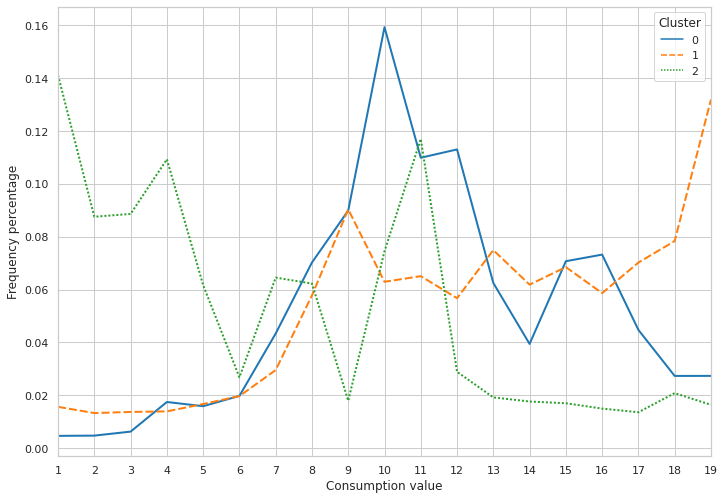

In [259]:
_, ax = plt.subplots()

sns.lineplot(data=df_fp, linewidth=2, palette='tab10')

ax.set_xlim(df_fp.index[0], df_fp.index[-1])
ax.set_xticks(range(df_fp.index[0], df_fp.index[-1] + 1))

ax.set(ylabel='Frequency percentage')
ax.legend(title='Cluster')

plt.show()

Our next analysis is to **count** the occurrence of consumption `0` and all other consumption values per cluster and display the results on a `bar` graph.

In [260]:
def get_zero_consumption_freq(df):
    """
    The function counts zero and all other consumption values per cluster.
    
    Args:
        df [pandas.DataFrame]: Occurrence data of each consumption value per cluster.
        
    Returns:
        [pandas.DataFrame]: Occurrence data of zero and all other consumption values per cluster.
    """
    
    df_z = pd.concat([df.iloc[0].to_frame(), df.iloc[1:,].sum()], axis=1)
    df_z.columns = ['Zero consumption', 'Other consumptions']
    df_z.index.names = ['Cluster']
    return df_z

In [261]:
df_z = get_zero_consumption_freq(get_consumption_freq(consumptions_c, n_clusters))

In [262]:
df_z.head()

,Zero consumption,Other consumptions
Cluster,,
0,57229,132068
1,153569,20491
2,108653,53036


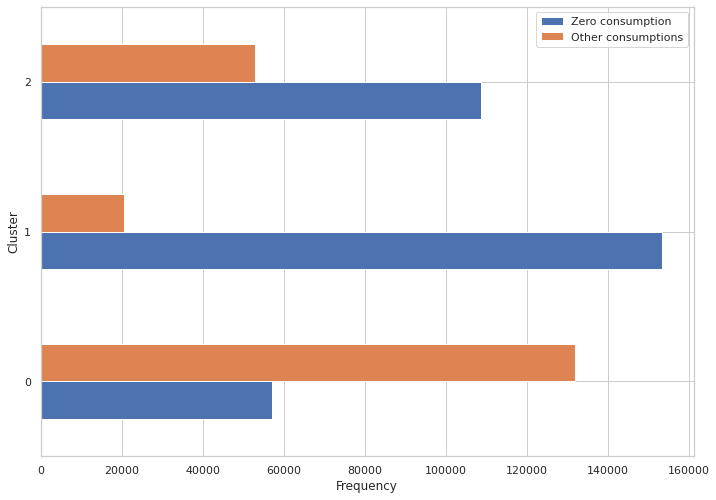

In [263]:
df_z.plot(kind='barh')
plt.xlabel('Frequency')
plt.show()

As before, we also change obtained data into percentages and plot it once again.

In [264]:
df_zp = get_freq_perc(df_z.copy(deep=True).T)
df_zp = df_zp.T

In [265]:
df_zp.head()

,Zero consumption,Other consumptions
Cluster,,
0,0.302324,0.697676
1,0.882276,0.117724
2,0.671988,0.328012


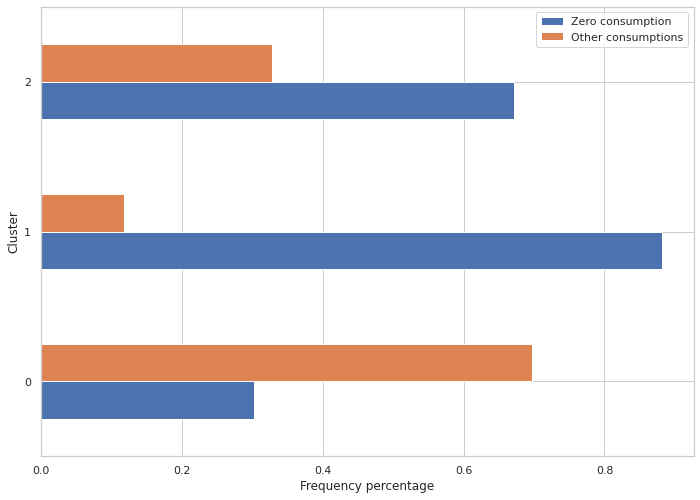

In [266]:
df_zp.plot(kind='barh')
plt.xlabel('Frequency percentage')
plt.show()

### 2.5 Cluster device types analysis

It is also interesting to check which **types of devices** were most often classified into which cluster. For this purpose, we define the function below and plot data on the `Venn` graph.

In [267]:
def get_unique_cluster_tags(df, n_clusters):
    """
    The function obtains number of each device type occurence per cluster.
    
    Args:
        df         [pandas.DataFrame]: Data frame of vector names and their clusters.
        n_clusters [int]:              Number of clusters.
        
    Returns:
        [dict]: Number of each device type occurence per cluster.
    """
    
    return {i:Counter([j.rsplit('_')[1] for j in get_cluster_tags(df, i)]) for i in range(0, n_clusters)}

In [268]:
tags = get_unique_cluster_tags(df_tc, n_clusters)

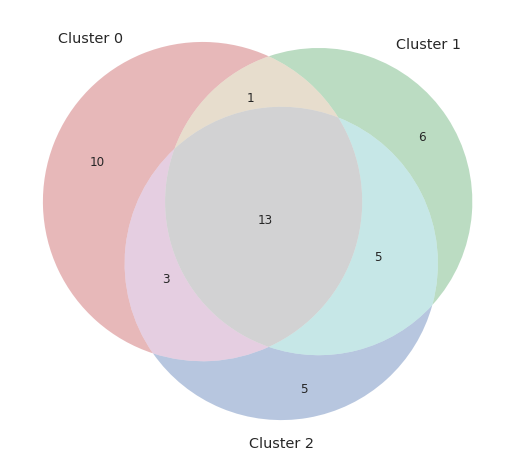

In [269]:
venn3([tags[i].keys() for i in range(0, n_clusters)], ['Cluster ' + str(i) for i in range(0, n_clusters)])
plt.show()

The function below changes previously obtained dictionary into a **data frame**. We will use the data frame to plot the data on `bar` graph.

In [270]:
def get_tags_freq(tags):
    """
    The function creates a data frame from number of each device type occurence per cluster dictionary.
    
    Args:
        tags [dict]: Number of each device type occurence per cluster.
        
    Returns:
        [pandas.DataFrame]: Number of each device type occurence per cluster.
    """
    
    df = pd.concat([pd.DataFrame.from_dict(tags[i], orient='index') for i in range(0, n_clusters)], axis=1)
    df.columns = [str(i) for i in range(0, n_clusters)]
    df.fillna(0, inplace=True)
    return df

In [271]:
df_t = get_tags_freq(tags)

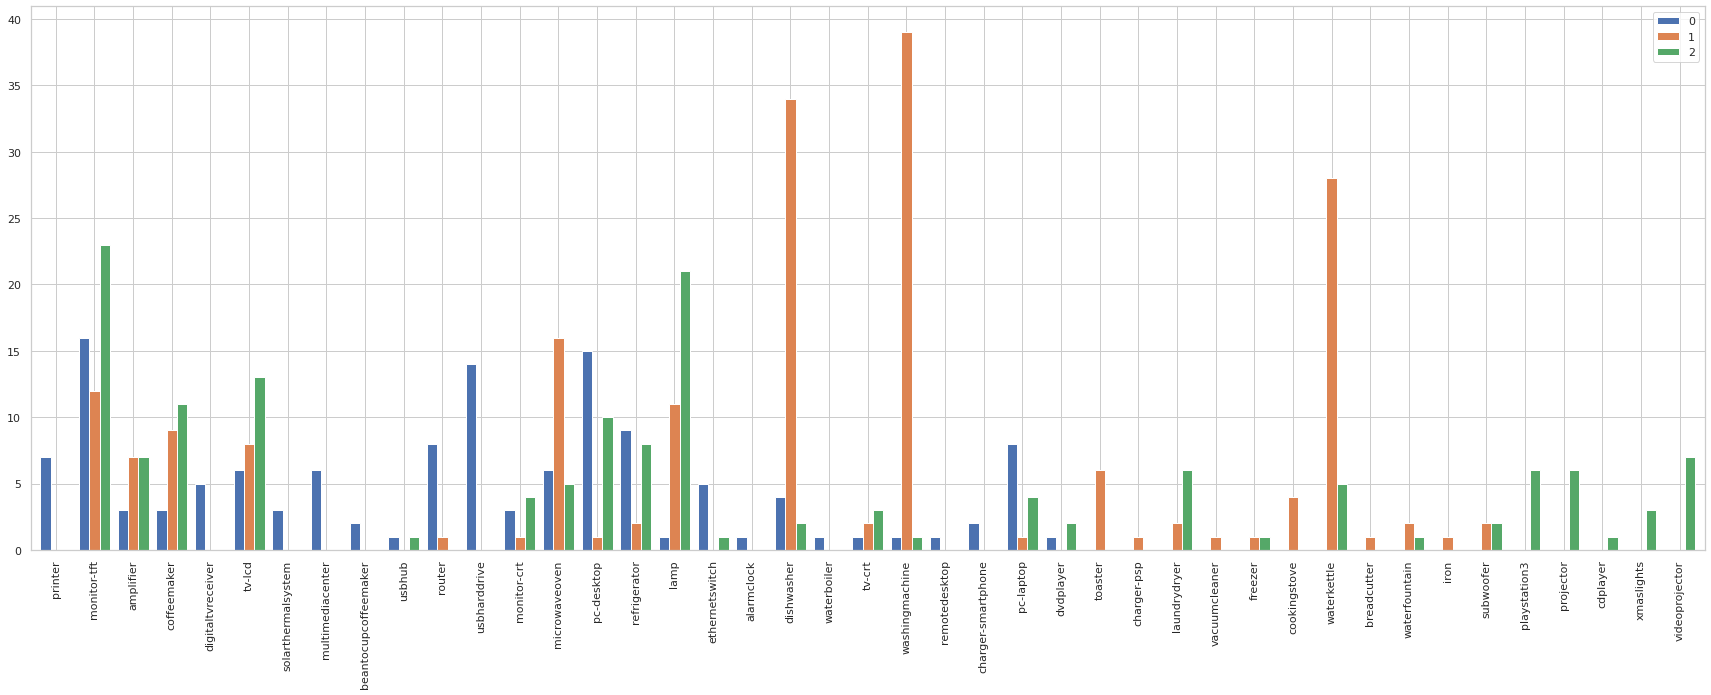

In [272]:
df_t.plot.bar(figsize=(30, 10), width=0.8)
plt.show()

As before, we change obtained data into percentages and plot them once again.

In [273]:
df_tp = get_freq_perc(df_t.copy(deep=True))

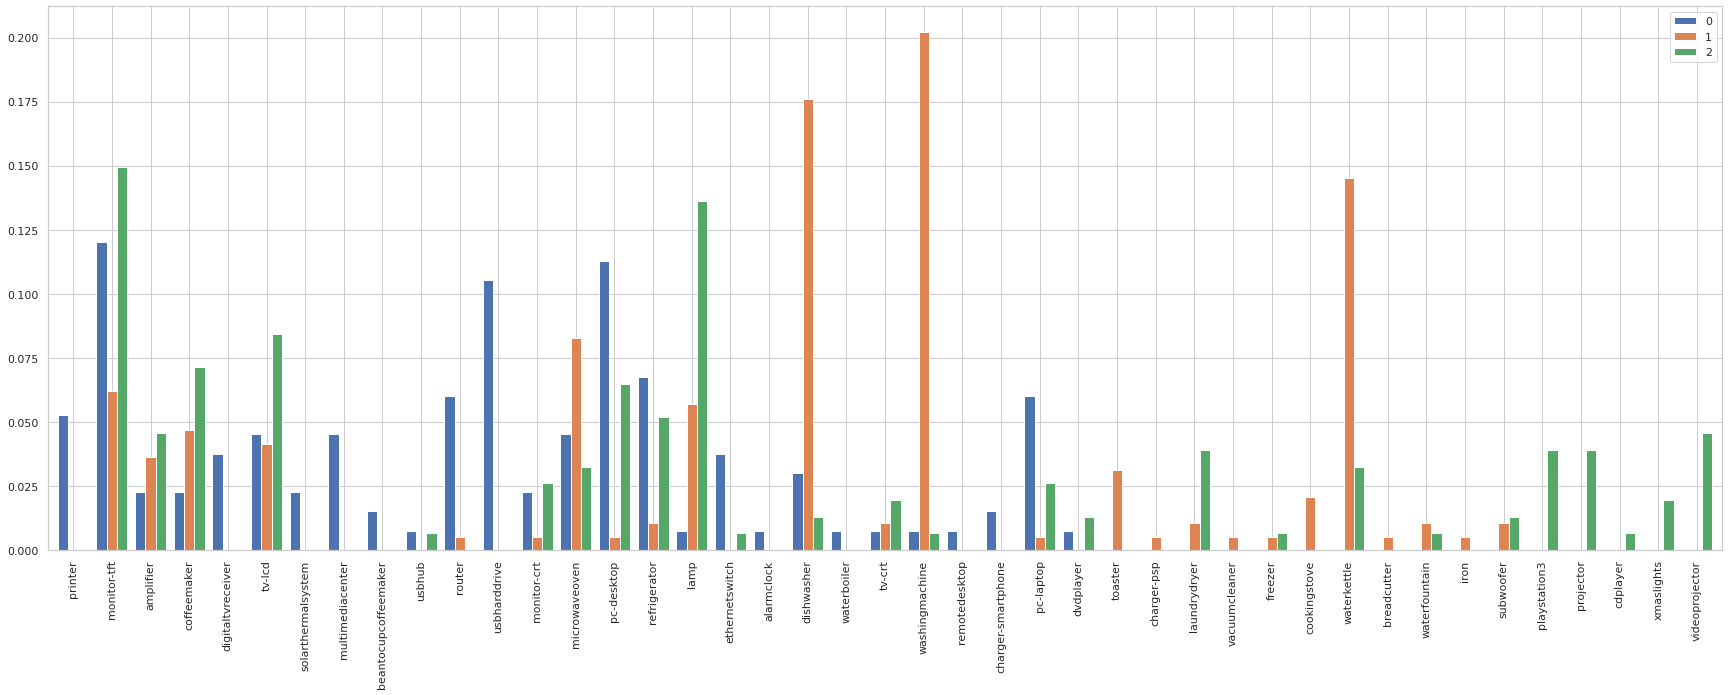

In [274]:
df_tp.plot.bar(figsize=(30, 10), width=0.8)
plt.show()

We can see that the devices are mostly arranged in clusters as follows:

**Cluster** `0`:
- printer
- digitaltvreceiver
- solarthermalsystem
- multimediacenter
- beantocupcoffeemaker
- usbhub
- router
- usbharddrive
- pc-desktop
- refrigerator
- ethernetswitch
- alarmclock
- waterboiler
- remotedesktop
- charger-smartphone
- pc-laptop

**Cluster** `1`:
- amplifier
- microwaveoven
- dishwasher
- washingmachine
- toaster
- charger-psp
- vacuumcleaner
- freezer
- cookingstove
- waterkettle
- breadcutter
- waterfountain
- iron
- subwoofer


**Cluster** `2`:
- monitor-tft
- amplifier
- coffeemaker
- tv-lcd
- usbhub
- monitor-crt
- lamp
- tv-crt
- dvdplayer
- laundrydryer
- freezer
- subwoofer
- playstation3
- projector
- cdplayer
- xmaslights
- videoprojector

<a id='3_classification'></a>

## 3. Classification

**The classification will be performed by predicting the type of device, according to a random pattern of its consumption.**

For this purpose, we will use the `Doc2Vec` model, as we are looking for the most similar vector in the model - in our case, vector represents the most similar device. First, we will create a new data set, convert each random consumption into a new vector and find its most similar device. The results will be evaluated using `top-1` and `top-5` accuracy.

### 3.1 Preparing samples data set

Here we define **new data set path**, which name is `samples`.

In [275]:
samples_path = 'datasets/samples/'

The function below is used to **create** a new `samples` data set. In general, consumption data is first read and then, to obtain a random sample, some percentage of first and last values is removed from it. 

In [276]:
def write_to_samples(consumptions_path, samples_path, drop_perc=0.2):
    """
    The function reads, prepares samples and writes them into a file.
    
    Args:
        consumptions_path [str]:   Path to read consumptions from.
        samples_path      [str]:   Path to write samples to.
        drop_perc         [float]: Percent of last consumption data to drop.
    
    Returns:
        Function does not return anything.
    """
    
    for dirname in os.listdir(consumptions_path):
            create_dirs(samples_path + dirname)
            
            for filename in os.listdir(consumptions_path + dirname):
                with open(consumptions_path + dirname + os.sep + filename, 'r') as f:
                    data = list(filter(str.strip, [r for r in csv.reader(f, delimiter=' ')][0]))
                
                with open(samples_path + dirname + os.sep + filename, 'w') as f:
                    f.write(' '.join(dropout_first_and_last(data, drop_perc)))

In [277]:
def dropout_first_and_last(array, drop_perc):
    """
    The function drops given percent of first and last consumption data.
    
    Args:
        array     [numpy.ndarray]: Consumption data to drop from.
        drop_perc [float]:         Percent of first and last consumption data to drop.
        
    Returns:
        [numpy.ndarray]: Consumption data on which dropping was performed.
    """
    
    return array[int(round(len(array) * drop_perc)):-int(round(len(array) * drop_perc))]

In [278]:
write_to_samples(consumptions_path, samples_path)

### 3.2 Getting similarities

**Similarities** will be obtained via the function defined below, which uses the `most_similar` function of the `Doc2Vec` model to find the most similar random consumption devices. 

In [279]:
def get_similarities(model, path, n=50):
    """
    The function obtains most similar random consumption devices.
    
    Args:
        model [gensim.Doc2Vec]: Doc2Vec model.
        path  [str]:            Path to read samples from.
        n     [int]:            Number of similarities to obtain.
    
    Returns:
        [dict]: Most similar random consumption devices.
    """
    
    similarities = {}
    
    for i in os.listdir(path):
        for j in os.listdir(path + i):
            vector = model.infer_vector(file_to_string_array(path + i + os.sep + j))
            similar = model.docvecs.most_similar(positive=[vector], topn=n)
            similarities[j[:-4]] = [k[0].rsplit('_')[1] for k in similar]
            
    return similarities

In [280]:
similarities = get_similarities(d2v_model, samples_path)

The obtained similarity results will be evaluated with a new function that acquires **`top-n` accuracy**.

In [281]:
def get_top_n_accuracy(similarities, n):
    """
    The function obtains accuracy of similarities.
    
    Args:
        similarities [dict]: Most similar random consumption devices.
        n            [int]:  Type of accuracy to obtain.
    
    Returns:
        [list]: Bools that indicate if device classification is correct.
    """
    
    return [True if i.rsplit('_')[1] in similarities[i][:n] else False for i in similarities]

In [282]:
top_1_accuracy = get_top_n_accuracy(similarities, 1)

In [283]:
top_5_accuracy = get_top_n_accuracy(similarities, 5)

### 3.3 Printing similarity results

Finally, we **review** the acquired similarities and **print** the `top-1` and `top-5` accuracy. 

In [284]:
def print_n_similarities(similarities, n):
    """
    The function prints a certain number of most similar random consumption devices.
    
    Args:
        similarities [dict]: Most similar random consumption devices.
        n            [int]:  Number of device similarities to print.
    
    Returns:
        Function does not return anything.
    """
    
    [print(i + '\n' + str(similarities[i][:n]) + '\n') for i in similarities]

In [285]:
def print_accuracy(accuracy):
    """
    The function calculates and prints classification accuracy.
    
    Args:
        accuracy [list]: Bools that indicate if device classification is correct.
    
    Returns:
        Function does not return anything.
    """
    
    print("{0:20} {1}".format('True predictions:', accuracy.count(True)))
    print("{0:20} {1}".format('False predictions:', accuracy.count(False)))
    print("{0:20} {1}".format('Accuracy:', round(accuracy.count(True) / len(accuracy), 3)))

Here we print **first** similarities and **`top-1` accuracy**.

In [286]:
print_n_similarities(similarities, 1)

0_waterboiler
['waterboiler']

2_subwoofer
['subwoofer']

3_subwoofer
['waterkettle']

0_subwoofer
['amplifier']

1_subwoofer
['microwaveoven']

2_digitaltvreceiver
['router']

3_digitaltvreceiver
['ethernetswitch']

0_digitaltvreceiver
['multimediacenter']

1_digitaltvreceiver
['digitaltvreceiver']

4_digitaltvreceiver
['digitaltvreceiver']

2_dvdplayer
['dvdplayer']

0_dvdplayer
['dvdplayer']

1_dvdplayer
['waterkettle']

23_pc-desktop
['pc-desktop']

3_pc-desktop
['pc-desktop']

5_pc-desktop
['monitor-tft']

9_pc-desktop
['lamp']

1_pc-desktop
['pc-desktop']

8_pc-desktop
['monitor-tft']

13_pc-desktop
['pc-desktop']

7_pc-desktop
['pc-desktop']

20_pc-desktop
['pc-desktop']

18_pc-desktop
['videoprojector']

0_pc-desktop
['pc-desktop']

22_pc-desktop
['monitor-tft']

11_pc-desktop
['pc-desktop']

17_pc-desktop
['pc-desktop']

10_pc-desktop
['amplifier']

14_pc-desktop
['pc-desktop']

2_pc-desktop
['ethernetswitch']

12_pc-desktop
['dishwasher']

6_pc-desktop
['monitor-tft']

25_pc-

In [287]:
print_accuracy(top_1_accuracy)

True predictions:    201
False predictions:   279
Accuracy:            0.419


Here we print first **five** similarities and **`top-5` accuracy**.

In [288]:
print_n_similarities(similarities, 5)

0_waterboiler
['waterboiler', 'laundrydryer', 'multimediacenter', 'lamp', 'monitor-tft']

2_subwoofer
['subwoofer', 'monitor-tft', 'monitor-tft', 'amplifier', 'laundrydryer']

3_subwoofer
['waterkettle', 'waterkettle', 'waterkettle', 'waterkettle', 'waterkettle']

0_subwoofer
['amplifier', 'subwoofer', 'monitor-tft', 'laundrydryer', 'laundrydryer']

1_subwoofer
['microwaveoven', 'waterkettle', 'monitor-crt', 'toaster', 'waterkettle']

2_digitaltvreceiver
['router', 'digitaltvreceiver', 'router', 'digitaltvreceiver', 'digitaltvreceiver']

3_digitaltvreceiver
['ethernetswitch', 'ethernetswitch', 'pc-desktop', 'router', 'digitaltvreceiver']

0_digitaltvreceiver
['multimediacenter', 'digitaltvreceiver', 'router', 'tv-lcd', 'printer']

1_digitaltvreceiver
['digitaltvreceiver', 'router', 'digitaltvreceiver', 'digitaltvreceiver', 'router']

4_digitaltvreceiver
['digitaltvreceiver', 'router', 'digitaltvreceiver', 'router', 'digitaltvreceiver']

2_dvdplayer
['dvdplayer', 'coffeemaker', 'coffeem

In [289]:
print_accuracy(top_5_accuracy)

True predictions:    310
False predictions:   170
Accuracy:            0.646


<a id='4_prediction'></a>

## 4. Prediction

**We will use the `Word2Vec` model to predict one category of the next device consumption.**

Before that, we will create two new data sets - the first will contain training consumption and the second testing consumption data. Then, `Word2Vec` model will try to predict the next word or in our case the next consumption vector. Prediction will be divided into devices, that are either on/off and all other devices. The results will be evaluated using `MSE` error.

### 4.1 Preparing forecast data sets

Here we define **new data set paths**, which names are `forecast-train` and `forecast-test`.

In [290]:
forecast_train_path = 'datasets/forecast-train/'

In [291]:
forecast_test_path = 'datasets/forecast-test/'

The function below is used to **create** two new data sets - `forecast-train` and `forecast-test`. Consumption data is read, divided into training and testing data and written to files.

In [292]:
def write_to_forecast(consumptions_path, forecast_train_path, forecast_test_path, drop_perc=0.3):
    """
    The function reads, prepares forecast train in test data and writes them into a file.
    
    Args:
        consumptions_path   [str]:   Path to read consumptions from.
        forecast_train_path [str]:   Path to write forecast train data to.
        forecast_test_path  [str]:   Path to write forecast test data to.
        drop_perc           [float]: Percent of first consumption data to drop.
        
    Returns:
        Function does not return anything.
    """
    
    for dirname in os.listdir(consumptions_path):
            create_dirs(forecast_train_path + dirname)
            create_dirs(forecast_test_path + dirname)
            
            for filename in os.listdir(consumptions_path + dirname):
                with open(consumptions_path + dirname + os.sep + filename, 'r') as f:
                    data = list(filter(str.strip, [r for r in csv.reader(f, delimiter=' ')][0]))
                
                with open(forecast_train_path + dirname + os.sep + filename, 'w') as f:
                    f.write(' '.join(dropout_last(data, drop_perc)))
                
                with open(forecast_test_path + dirname + os.sep + filename, 'w') as f:
                    f.write(' '.join(dropout_first(data, drop_perc)))

In [293]:
def dropout_first(array, drop_perc):
    """
    The function drops given percent of first consumption data.
    
    Args:
        array     [numpy.ndarray]: Consumption data to drop from.
        drop_perc [float]:         Percent of first consumption data to drop.
        
    Returns:
        [numpy.ndarray]: Consumption data on which dropping was performed.
    """
    
    return array[len(array) - int(round(len(array) * drop_perc)):]

In [294]:
write_to_forecast(consumptions_path, forecast_train_path, forecast_test_path)

### 4.2 Getting predictions

Here we define which types of devices are **on/off** devices.

In [295]:
of_devices = ['amplifier',
              'microwaveoven',
              'dishwasher',
              'washingmachine',
              'toaster',
              'charger-psp',
              'vacuumcleaner',
              'freezer',
              'cookingstove',
              'waterkettle',
              'breadcutter',
              'waterfountain',
              'iron',
              'subwoofer',
              'dvdplayer',
              'videoprojector',
              'projector',
              'tv-lcd',
              'laundrydryer',
              'lamp',
              'monitor-tft']

**Predictions** will be obtained from the function below, which uses the `predict_output_word` function of the `Word2Vec` model to predict the next consumption category. 

In [296]:
def get_predictions(model, path, n=5, of=False):
    """
    The function obtains predictions of the devices next consumption category.
    
    Args:
        model [gensim.Word2Vec]: Word2Vec model.
        path  [str]:             Path to read forecast train data from.
        n     [int]:             Number of predictions to obtain.
        of    [bool]:            Bool indicating if consumptions of on/off devices are being predicted.
    
    Returns:
        [dict]: Predictions of the devices next consumption category.
    """
    
    predictions = {}
    
    for i in os.listdir(path):
        if (of and i in of_devices) or (not of and i not in of_devices):
            for j in os.listdir(path + i):
                prediction = model.predict_output_word(file_to_string_array(path + i + os.sep + j), n)
                predictions[j[:-4]] = [int(k[0]) for k in prediction]
    
    return predictions

In [297]:
predictions = get_predictions(w2v_model, forecast_train_path)

In [298]:
of_predictions = get_predictions(w2v_model, forecast_train_path, of=True)

The obtained predictions will be evaluated with a new function that acquires **`MSE` errors**.

In [299]:
def get_mse(predictions, path):
    """
    The function obtains MSE errors of next consumption category predictions. 
    
    Args:
        predictions [dict]: Predictions of the devices next consumption category.
        path        [str]:  Path to read forecast test data from.
    
    Returns:
        [dict]: MSE errors of next consumption category predictions.
    """
    
    mse = {}
    
    for i in predictions:
        actual = file_to_string_array(path + i.rsplit('_')[1] + os.sep + i + '.csv')
        mse[i] = mean_squared_error([int(actual[0])], [predictions[i][0]])
    
    return mse

In [300]:
mse = get_mse(predictions, forecast_test_path)

In [301]:
of_mse = get_mse(of_predictions, forecast_test_path)

### 4.3 Printing prediction results

The defined function **prints** next consumption category predictions `MSE` errors.

In [302]:
def print_mse(mse):
    """
    The function prints MSE errors.
    
    Args:
        mse [dict]: MSE errors.
    
    Returns:
        Function does not return anything.
    """
    
    [print("{0:25} {1}".format(i, mse[i])) for i in mse]

Here we print `MSE` errors for **other** devices.

In [303]:
print_mse(mse)

0_waterboiler             196.0
2_digitaltvreceiver       4.0
3_digitaltvreceiver       0.0
0_digitaltvreceiver       1.0
1_digitaltvreceiver       25.0
4_digitaltvreceiver       16.0
23_pc-desktop             0.0
3_pc-desktop              0.0
5_pc-desktop              0.0
9_pc-desktop              400.0
1_pc-desktop              36.0
8_pc-desktop              0.0
13_pc-desktop             0.0
7_pc-desktop              400.0
20_pc-desktop             0.0
18_pc-desktop             0.0
0_pc-desktop              256.0
22_pc-desktop             400.0
11_pc-desktop             0.0
17_pc-desktop             4.0
10_pc-desktop             0.0
14_pc-desktop             0.0
2_pc-desktop              121.0
12_pc-desktop             0.0
6_pc-desktop              0.0
25_pc-desktop             121.0
21_pc-desktop             400.0
19_pc-desktop             0.0
16_pc-desktop             4.0
24_pc-desktop             0.0
15_pc-desktop             0.0
4_pc-desktop              0.0
7_pc-laptop          

In [304]:
print(sum(mse.values()))

11793.0


Here we print `MSE` errors for **on/off** devices. 

In [305]:
print_mse(of_mse)

2_subwoofer               0.0
3_subwoofer               0.0
0_subwoofer               0.0
1_subwoofer               0.0
2_dvdplayer               324.0
0_dvdplayer               0.0
1_dvdplayer               0.0
3_videoprojector          0.0
2_videoprojector          0.0
4_videoprojector          0.0
1_videoprojector          0.0
0_videoprojector          9.0
6_videoprojector          0.0
5_videoprojector          1.0
11_lamp                   400.0
26_lamp                   0.0
4_lamp                    0.0
31_lamp                   0.0
9_lamp                    400.0
10_lamp                   0.0
5_lamp                    400.0
19_lamp                   0.0
7_lamp                    0.0
1_lamp                    400.0
6_lamp                    400.0
13_lamp                   0.0
21_lamp                   0.0
14_lamp                   0.0
16_lamp                   0.0
23_lamp                   0.0
3_lamp                    400.0
24_lamp                   0.0
27_lamp                   

In [306]:
print(sum(of_mse.values()))

15107.0


For the purpose of comparing the results with new, we **merge** `MSE` error variables and **sort** them alphabetically.

In [307]:
mse.update(of_mse)

In [308]:
pre_mse = dict(sorted(mse.items()))

In [309]:
print_mse(pre_mse)

0_alarmclock              0.0
0_amplifier               0.0
0_beantocupcoffeemaker    1.0
0_breadcutter             0.0
0_cdplayer                36.0
0_charger-psp             0.0
0_charger-smartphone      0.0
0_coffeemaker             0.0
0_cookingstove            0.0
0_digitaltvreceiver       1.0
0_dishwasher              0.0
0_dvdplayer               0.0
0_ethernetswitch          36.0
0_freezer                 0.0
0_iron                    0.0
0_lamp                    0.0
0_laundrydryer            0.0
0_microwaveoven           9.0
0_monitor-crt             400.0
0_monitor-tft             0.0
0_multimediacenter        1.0
0_pc-desktop              256.0
0_pc-laptop               400.0
0_playstation3            0.0
0_printer                 0.0
0_projector               0.0
0_refrigerator            0.0
0_remotedesktop           9.0
0_router                  49.0
0_solarthermalsystem      0.0
0_subwoofer               0.0
0_toaster                 0.0
0_tv-crt                  0.0
0

<a id='5_rnn_forecasting'></a>

## 5. RNN Forecasting

**The next consumption prediction will be once again performed using the `RNN` neural network, as we will work with time-series data.**

This time, we will define a `GRU` neural network and train it to predict the next devices consumption. The results will be evaluated with using `MSE` error.

> [*GRU applies a multi-layer gated recurrent unit RNN to an input sequence.*](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

### 5.1 Preparing training data

The **sequence length** number represents the size of the data sequences that will be used to train the model.

In [310]:
seq_length = 10

We also define a `MinMaxScaler` object, so we can **scale** data between numbers `-1` and `1`.

> [*Scaler transforms each feature individually such that it is in the given range on the training set, e.g. between zero and one.*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [311]:
sc = MinMaxScaler(feature_range=(-1, 1))

We will divide the data into **sequences** using the function below. The function prepares several sequences of  consecutive consumptions `x` and their target consumptions `y`. 

In [312]:
def sliding_windows(data, seq_length):
    """
    The function divides data into sequences and their target consumptions.
    
    Args:
        data       [numpy.ndarray]: Data to divide into sequences.
        seq_length [int]:           One sequence length.
    
    Returns:
        [numpy.ndarray, numpy.ndarray]: Sequences and their target consumptions.
    """
    
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
        
    return np.array(x), np.array(y)

The following function is used to **load and prepare training data**. The data is read first, then scaled and divided into sequences.

In [313]:
def load_train_data(path, sc, seq_length):
    """
    The function loads and prepares training data.
    
    Args:
        path       [str]:                  Path to read training data from.
        sc         [sklearn.MinMaxScaler]: Min-max scaler.
        seq_length [int]:                  One sequence length.
    
    Returns:
        [numpy.ndarray, numpy.ndarray]: Training x and y data.
    """
    
    x = None
    y = None
    
    for dirname in os.listdir(path):
        for filename in os.listdir(path + dirname):
            data = file_to_int_array(path + dirname + os.sep + filename)
            scaled = sc.fit_transform(data.reshape(-1, 1))
            _x, _y = sliding_windows(scaled, seq_length)

            if x is None:
                x, y = _x, _y
            else:
                x = np.concatenate((x, _x), axis=0)
                y = np.concatenate((y, _y), axis=0)
                
    return x, y

In [314]:
x_train, y_train = load_train_data(forecast_train_path, sc, seq_length)

The prepared data is also converted into `torch.Variable` objects. 

In [315]:
x_train = Variable(torch.Tensor(x_train))
y_train = Variable(torch.Tensor(y_train))

### 5.2 Model definition

The **GRU class** represents a neural network model that we will train to predict the next device consumption with.

1. The class accepts the parameters input size, hidden size, output size, and number of layers.
2. The GRU neural network is defined with the `nn.GRU` object.
3. Fully connected layer is defined with `nn.Linear` object.
4. In the forward function, we define how the model will work from input to output layer.

In [316]:
class GRU(nn.Module):
    """
    A class used to represent GRU neural network model.
    
    Attributes:
        input_size  [int]: Size of input layer.
        hidden_size [int]: Size of hidden layer.
        output_size [int]: Size of output layer.
        n_layers    [int]: Number of layers.
    """
    
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_size))
        
        _, h_out = self.gru(x, h)
        
        h_out = h_out.view(-1, self.hidden_size)
        
        return self.fc(h_out)

Here we set neural network **parameters** and **define** the `GRU` object.

In [317]:
input_size = 1
hidden_size = 25
output_size = 1
n_layers = 1

In [318]:
gru = GRU(input_size, hidden_size, output_size, n_layers)

### 5.3 Model training

Before training, we need to determine the number of **epochs** and **learning rate**. 

In [319]:
n_epochs = 100
learning_rate = 0.01

It is also necessary to define a **criterion function** and an **optimization algorithm**. 

In [320]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

The following code is used to **train** the `GRU` model. We insert the training data over and over again, calculate the loss, and adjust the neural network.

In [321]:
for i in range(n_epochs):
    outputs = gru(x_train)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print('Epoch: %d, loss: %1.5f' % (i, loss.item()))

print('Epoch: %d, loss: %1.5f' % (i, loss.item()))

Epoch: 0, loss: 0.81603
Epoch: 10, loss: 0.21242
Epoch: 20, loss: 0.15824
Epoch: 30, loss: 0.14002
Epoch: 40, loss: 0.12855
Epoch: 50, loss: 0.12484
Epoch: 60, loss: 0.12282
Epoch: 70, loss: 0.12187
Epoch: 80, loss: 0.12147
Epoch: 90, loss: 0.12123
Epoch: 99, loss: 0.12104


### 5.4 Model testing

Before testing, we prepare `MSE` dictionary and evaluate the model.

In [322]:
gru_mse = {}

In [323]:
print(gru.eval())

GRU(
  (gru): GRU(1, 25, batch_first=True)
  (fc): Linear(in_features=25, out_features=1, bias=True)
)


With below function, **testing data will we loaded and prepared**.

In [324]:
def load_test_data(path, sc, seq_length):
    """
    The function loads and prepares testing data.
    
    Args:
        path       [str]:                  Path to read testing data from.
        sc         [sklearn.MinMaxScaler]: Min-max scaler.
        seq_length [int]:                  One sequence length.
    
    Returns:
        [numpy.ndarray, numpy.ndarray]: Training x and y data.
    """
    
    data = file_to_int_array(path)     
    scaled = sc.transform(data.reshape(-1, 1))
    return sliding_windows(scaled, seq_length)

The following code is used to **test** the predictions. First, we load test data, convert it into `torch.Variable` objects and then predict the next consumption. After that we inverse the data and calculate the `MSE` error.

In [325]:
for dirname in os.listdir(forecast_test_path):
    for filename in os.listdir(forecast_test_path + dirname):
        x_test, y_test = load_test_data(forecast_test_path + dirname + os.sep + filename, sc, seq_length)

        x_test = Variable(torch.Tensor(x_test))
        y_test = Variable(torch.Tensor(y_test))

        pred = gru(x_test)

        y_pred = sc.inverse_transform(pred.data.numpy())
        y_true = sc.inverse_transform(y_test.data.numpy())

        gru_mse[filename[:-4]] = mean_squared_error(y_true, y_pred)

Now we can plot the `0_charger-smartphone` device predictions on the graph.

In [326]:
print(filename[:-4])

0_charger-smartphone


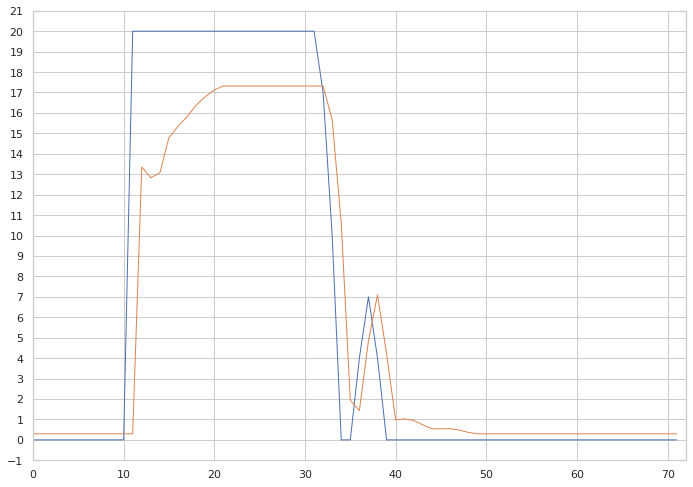

In [327]:
plt.plot(y_true, linewidth=1)
plt.plot(y_pred, linewidth=1)

plt.axis([0, len(y_pred), 0, 20])
plt.yticks(np.arange(-1, 22, 1))

plt.show()

Here we **sort** the `MSE` values alphabetically and **print** them.

In [328]:
gru_mse = dict(sorted(gru_mse.items()))

In [329]:
print_mse(gru_mse)

0_alarmclock              6.036890029907227
0_amplifier               6.459870338439941
0_beantocupcoffeemaker    2.410295009613037
0_breadcutter             9.96654224395752
0_cdplayer                6.813695907592773
0_charger-psp             0.08824290335178375
0_charger-smartphone      12.550207138061523
0_coffeemaker             0.08824289590120316
0_cookingstove            4.653611660003662
0_digitaltvreceiver       1.7190954685211182
0_dishwasher              0.08824289590120316
0_dvdplayer               11.759687423706055
0_ethernetswitch          2.640399932861328
0_freezer                 55.34463119506836
0_iron                    3.7361083030700684
0_lamp                    14.540789604187012
0_laundrydryer            0.08824289590120316
0_microwaveoven           1.3969545364379883
0_monitor-crt             5.4900712966918945
0_monitor-tft             9.039022445678711
0_multimediacenter        5.764163017272949
0_pc-desktop              3.5742545127868652
0_pc-laptop      

### 5.5 Comparing MSE values

The function prints **both** `MSE` dictionaries together.

In [330]:
def print_both_mses(gru_mse, pre_mse):
    """
    The function prints both MSE errors.
    
    Args:
        gru_mse [dict]: GRU MSE errors.
        pre_mse [dict]: Predifction MSE errors.
    
    Returns:
        Function does not return anything.
    """
    
    [print("{0:25} {1:25} {2:25}".format(i, gru_mse[i], pre_mse[i])) for i in gru_mse]

In [331]:
print_both_mses(gru_mse, pre_mse)

0_alarmclock                      6.036890029907227                       0.0
0_amplifier                       6.459870338439941                       0.0
0_beantocupcoffeemaker            2.410295009613037                       1.0
0_breadcutter                      9.96654224395752                       0.0
0_cdplayer                        6.813695907592773                      36.0
0_charger-psp                   0.08824290335178375                       0.0
0_charger-smartphone             12.550207138061523                       0.0
0_coffeemaker                   0.08824289590120316                       0.0
0_cookingstove                    4.653611660003662                       0.0
0_digitaltvreceiver              1.7190954685211182                       1.0
0_dishwasher                    0.08824289590120316                       0.0
0_dvdplayer                      11.759687423706055                       0.0
0_ethernetswitch                  2.640399932861328             

Here we calculate and print **sum of all `MSE` values** for both `Word2Vec` and `RNN` neural network predictions.

In [332]:
def sum_mse(mse):
    """
    The function sums MSE errors.
    
    Args:
        mse [dict]: MSE errors.
    
    Returns:
        [float]: The sum of MSE errors. 
    """
    
    return round(sum(mse.values()), 2)

In [333]:
print(sum_mse(gru_mse))

4009.1


In [334]:
print(sum_mse(pre_mse))

26900.0


Here we count and print **number of zero `MSE` values** for both `Word2Vec` and `RNN` neural network predictions.

In [335]:
def count_zero_mse(mse):
    """
    The function counts number of zero MSE errors.
    
    Args:
        mse [dict]: MSE errors.
    
    Returns:
        [float]: Number of zero MSE errors.
    """
    
    return sum(i == 0 for i in mse.values())

In [336]:
print(count_zero_mse(gru_mse))

0


In [337]:
print(count_zero_mse(pre_mse))

324


#### Acknowledgements
_Contains information from the tracebase data set, which is made available at  [http://www.tracebase.org](http://www.tracebase.org/)  under the Open Database License (ODbL)._